# Importing Basic required libraries

In [1]:
import pandas as pd
import numpy as np
import arviz as az

# Load dataset


In [2]:
df_brazil = pd.read_excel(r'alldatasets.xlsx',sheet_name='Brazil')

In [3]:
df_brazil.head()

,childid,country,height,stunting_2cat,EDUYRS2,z_score,agegapr1,momeduyrsr1,chsexr1,agemonr1,hhsizer1,wi_newr1,job_cat,pvt_sector,earn_usd
0,BR1,Brazil,180.35,0.0,16.0,0.399053,0.0,5.0,1,50.0,3.0,0.306352,3.0,1,290.316010
1,BR2,Brazil,164.95,0.0,15.0,0.002132,NaN,5.0,0,52.0,3.0,0.533106,3.0,1,109.973544
2,BR8,Brazil,167.10,1.0,5.0,-2.061853,6.0,5.0,1,49.0,12.0,0.115514,3.0,1,109.973544
3,BR12,Brazil,174.75,0.0,13.0,1.351661,2.0,6.0,1,51.0,5.0,0.597647,3.0,1,1060.838040
4,BR14,Brazil,179.35,0.0,11.0,0.557821,NaN,10.0,1,50.0,3.0,0.483788,3.0,1,353.612680


In [4]:
df_brazil.columns

Index(['childid', 'country', 'height', 'stunting_2cat', 'EDUYRS2', 'z_score',
       'agegapr1', 'momeduyrsr1', 'chsexr1', 'agemonr1', 'hhsizer1',
       'wi_newr1', 'job_cat', 'pvt_sector', 'earn_usd'],
      dtype='object')

Stunting Dataset - Brazil - Private Sector

Stunting Dataset - Brazil - Private Sector
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 2398 

    :Number of Attributes of Interest: 10 numeric/categorical predictive. 

    :Attribute Information (in order):
        - stunting_2cat   Stunting categorized by HAZ score 
        - agemonr1        Age of child in months
        - chsexr1         Sex of child in months categorized 
        - momeduyrsr1     Maternal education in years
        - hhsizer1        Number of House hold members
        - wi_newr1        Wealth 
        - agegapr1        Age gap between parents
        - height          Adulthood height (outcome variable)
        - z_score         Cognitive score converted to Zscore (outcome variable)
        - EDUYRS2         Total number of years of education attained (outcome variable)

In [5]:
from scipy import stats
import scipy.stats as stats

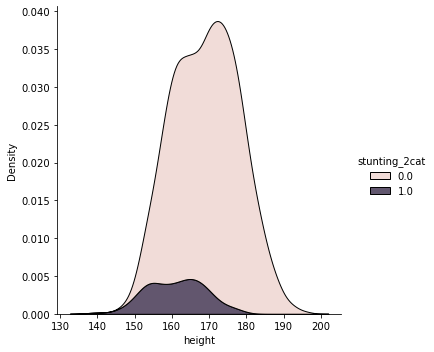

In [6]:
import seaborn as sns
sns.displot(df_brazil, x="height", hue="stunting_2cat", kind="kde", multiple="stack")

In [7]:
df_brazil=df_brazil.astype({"chsexr1": 'object', "job_cat": 'object', "pvt_sector": 'object',"stunting_2cat": 'object'})

In [8]:
df_outlier=df_brazil.copy()

In [9]:
total = df_outlier.isnull().sum().sort_values(ascending=False)
percent = (df_outlier.isnull().sum()/df_outlier.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
missing_data.loc[missing_data['Missing Percent'] > 95]

,Total,Missing Percent


In [10]:
df_outlier=df_outlier.select_dtypes(include=['int64','floating'])

In [11]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
agegapr1       float64
momeduyrsr1    float64
agemonr1       float64
hhsizer1       float64
wi_newr1       float64
earn_usd       float64
dtype: object

In [12]:
import warnings

warnings.filterwarnings('ignore')

In [13]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
agegapr1       float64
momeduyrsr1    float64
agemonr1       float64
hhsizer1       float64
wi_newr1       float64
earn_usd       float64
dtype: object

# Outlier Cappping (Winsorization)

Machine learning algorithms are very sensitive to the range and distribution of attribute values. Data outliers can spoil and mislead the training process resulting in longer training times, less accurate models and ultimately poorer results Compared with deletion of outliers in this study, the outliers were treated. The outliers were detected using the Inter Quartile Range (IQR) method which is beyond the range of -1.5 x IQR to 1.5 x IQR treated as outliers. We used outlier capping strategy (Winsorization) where observations larger than the 99th percentile to be equal to the 99th percentile value and observations smaller than the 1thpercentile to be equal to the 1th percentile value.

In [14]:
def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64') | ((df[col].dtype)=='float32')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df



In [15]:
final_df=cap_data(df_outlier)

capping the  height
capping the  EDUYRS2
capping the  z_score
capping the  agegapr1
capping the  momeduyrsr1
capping the  agemonr1
capping the  hhsizer1
capping the  wi_newr1
capping the  earn_usd


# Feature Engineering -  Imputation

Compared with deletion or tolerance of missing data imputation is a more optimal technique for coping with missing data. Imputation techniques make the consequence of statistical analyses and data processing more accurate and reliable. Consequently, missing data imputation draws increasing attentions. Here we used KNN imputation which is a widely used instance-based, lazy-learning algorithm. The basic assumption behind instance-based learning methods is that the instances of a dataset with missing values would lie close to other instances with similar properties

In [16]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [17]:
df_brazil=df_brazil.drop(['childid','country'],axis=1)

In [18]:
all_category_features=df_brazil.select_dtypes(include='object')

In [19]:
all_category_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398 entries, 0 to 2397
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   stunting_2cat  2140 non-null   object
 1   chsexr1        2398 non-null   object
 2   job_cat        2396 non-null   object
 3   pvt_sector     2398 non-null   object
dtypes: object(4)
memory usage: 75.1+ KB


# KNN for Categories

In [20]:
mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df

In [21]:
df_cat_imp=imputation(all_category_features,['stunting_2cat','chsexr1','job_cat','pvt_sector'])

In [22]:
df_cat_imp.isnull().sum().sort_values(ascending = False)

pvt_sector       0
job_cat          0
chsexr1          0
stunting_2cat    0
dtype: int64

In [23]:
df_cat_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398 entries, 0 to 2397
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   stunting_2cat  2398 non-null   float64
 1   chsexr1        2398 non-null   int64  
 2   job_cat        2398 non-null   float64
 3   pvt_sector     2398 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 75.1 KB


# KNN for numerics

In [24]:
df_knn=final_df.copy()

In [25]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_num_imp = pd.DataFrame(imputer.fit_transform(df_knn),columns = df_knn.columns)

In [26]:
df_num_imp.head()

,height,EDUYRS2,z_score,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn_usd
0,180.35,16.0,0.399053,0.0,5.0,50.0,3.00,0.306352,290.316010
1,164.95,15.0,0.002132,3.0,5.0,50.0,3.00,0.533106,109.973544
2,167.10,5.0,-2.061853,6.0,5.0,49.0,11.09,0.115514,109.973544
3,174.75,13.0,1.351661,2.0,6.0,50.0,5.00,0.597647,1060.838040
4,179.35,11.0,0.557821,5.2,10.0,50.0,3.00,0.483788,353.612680


In [27]:
df_outlier_concat = pd.concat([df_num_imp, df_cat_imp], axis=1)
df_outlier_concat.head()

,height,EDUYRS2,z_score,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,180.35,16.0,0.399053,0.0,5.0,50.0,3.00,0.306352,290.316010,0.0,1,3.0,1
1,164.95,15.0,0.002132,3.0,5.0,50.0,3.00,0.533106,109.973544,0.0,0,3.0,1
2,167.10,5.0,-2.061853,6.0,5.0,49.0,11.09,0.115514,109.973544,1.0,1,3.0,1
3,174.75,13.0,1.351661,2.0,6.0,50.0,5.00,0.597647,1060.838040,0.0,1,3.0,1
4,179.35,11.0,0.557821,5.2,10.0,50.0,3.00,0.483788,353.612680,0.0,1,3.0,1


In [28]:
df_outlier_concat=df_outlier_concat.astype({"stunting_2cat": 'int64'})

In [29]:
df_outlier_concat.head()

,height,EDUYRS2,z_score,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,180.35,16.0,0.399053,0.0,5.0,50.0,3.00,0.306352,290.316010,0,1,3.0,1
1,164.95,15.0,0.002132,3.0,5.0,50.0,3.00,0.533106,109.973544,0,0,3.0,1
2,167.10,5.0,-2.061853,6.0,5.0,49.0,11.09,0.115514,109.973544,1,1,3.0,1
3,174.75,13.0,1.351661,2.0,6.0,50.0,5.00,0.597647,1060.838040,0,1,3.0,1
4,179.35,11.0,0.557821,5.2,10.0,50.0,3.00,0.483788,353.612680,0,1,3.0,1


In [30]:
df_knn_imp=df_outlier_concat.copy()

# Bayesian

The best library for probabilistic programming and Bayesian Inference in Python is currently PyMC3. It includes numerous utilities for constructing Bayesian Models and using MCMC methods to infer the model parameters. We will be using the Generalized Linear Models (GLM) module of PyMC3, in particular, the GLM.from_formula function which makes constructing Bayesian Linear Models extremely simple.
There are only two steps we need to do to perform Bayesian Linear Regression with this module:
Build a formula relating the features to the target and decide on a prior distribution for the data likelihood
Sample from the parameter posterior distribution using MCMC

The priors are chosen so that they contain information about the range of possible values for a parameter and the plausible shape of the distribution of these values. The model parameters priors are modeled as a normal distribution. The Bayesian approach is considered flexible as it able to involve prior information about the underlying parameters with information from country level estimates

In [31]:
Y = df_knn_imp['height']
X = df_knn_imp[['stunting_2cat', 'agegapr1', 'momeduyrsr1', 'chsexr1', 'agemonr1','wi_newr1',
       'hhsizer1']]

In [33]:
import pymc3 as pm

with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 168.7, sd = 10)
    
    # Slope 
    stunting_2cat = pm.Normal('stunting_2cat', mu = 1, sd = 7.8)
    agemonr1        = pm.Normal('agemonr1', mu = 1, sd = 7.8)  
    chsexr1       = pm.Normal('chsexr1', mu = 1, sd = 7.8)  
    agegapr1        = pm.Normal('agegapr1', mu = 1, sd = 7.8)   
    momeduyrsr1     = pm.Normal('momeduyrsr1', mu = 1, sd = 7.8)  
    hhsizer1        = pm.Normal('hhsizer1', mu = 1, sd = 7.8)  
    wi_newr1        = pm.Normal('wi_newr1', mu = 1, sd = 7.8)
   
    
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + stunting_2cat * X.loc[:, 'stunting_2cat'] + agemonr1 * X.loc[:, 'agemonr1'] +     chsexr1 * X.loc[:, 'chsexr1'] +  agegapr1 * X.loc[:, 'agegapr1'] +  momeduyrsr1 * X.loc[:, 'momeduyrsr1']     +  hhsizer1 * X.loc[:, 'hhsizer1'] +  wi_newr1 * X.loc[:, 'wi_newr1'] 


    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = Y.values)
    
    # Sampler
    step = pm.NUTS(target_accept=0.95)

    # Posterior distribution
    linear_trace = pm.sample(10000, step, tune=2000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, wi_newr1, hhsizer1, momeduyrsr1, agegapr1, chsexr1, agemonr1, stunting_2cat, Intercept]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 266 seconds.


The sampler runs for a few minutes and our results are stored in normal_trace. This contains all the samples for every one of the model parameters (except the tuning samples which are discarded). The trace is essentially our model because it contains all the information we need to perform inference. To get an idea of what Bayesian Linear Regression does, we can examine the trace using built-in functions in PyMC3.

In [34]:
az.summary(linear_trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,159.464,1.537,156.608,162.389,0.011,0.008,20931.0,25220.0,1.0
stunting_2cat,-7.645,0.427,-8.434,-6.838,0.002,0.001,44370.0,28179.0,1.0
agemonr1,0.024,0.034,-0.038,0.089,0.000,0.000,22068.0,26500.0,1.0
chsexr1,12.680,0.244,12.224,13.137,0.001,0.001,37978.0,29779.0,1.0
agegapr1,-0.042,0.035,-0.109,0.021,0.000,0.000,41690.0,28958.0,1.0
momeduyrsr1,0.189,0.037,0.120,0.259,0.000,0.000,34426.0,30488.0,1.0
hhsizer1,0.061,0.074,-0.076,0.203,0.000,0.000,38461.0,30230.0,1.0
wi_newr1,1.019,0.791,-0.407,2.565,0.004,0.003,33736.0,30737.0,1.0
sigma,5.845,0.085,5.685,6.004,0.000,0.000,45337.0,28209.0,1.0


On the left, we have a KDE plot, — for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.

The above plot has one row for each parameter. 


We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'stunting_2cat'}>,
        <AxesSubplot:title={'center':'stunting_2cat'}>],
       [<AxesSubplot:title={'center':'agemonr1'}>,
        <AxesSubplot:title={'center':'agemonr1'}>],
       [<AxesSubplot:title={'center':'chsexr1'}>,
        <AxesSubplot:title={'center':'chsexr1'}>],
       [<AxesSubplot:title={'center':'agegapr1'}>,
        <AxesSubplot:title={'center':'agegapr1'}>],
       [<AxesSubplot:title={'center':'momeduyrsr1'}>,
        <AxesSubplot:title={'center':'momeduyrsr1'}>],
       [<AxesSubplot:title={'center':'hhsizer1'}>,
        <AxesSubplot:title={'center':'hhsizer1'}>],
       [<AxesSubplot:title={'center':'wi_newr1'}>,
        <AxesSubplot:title={'center':'wi_newr1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

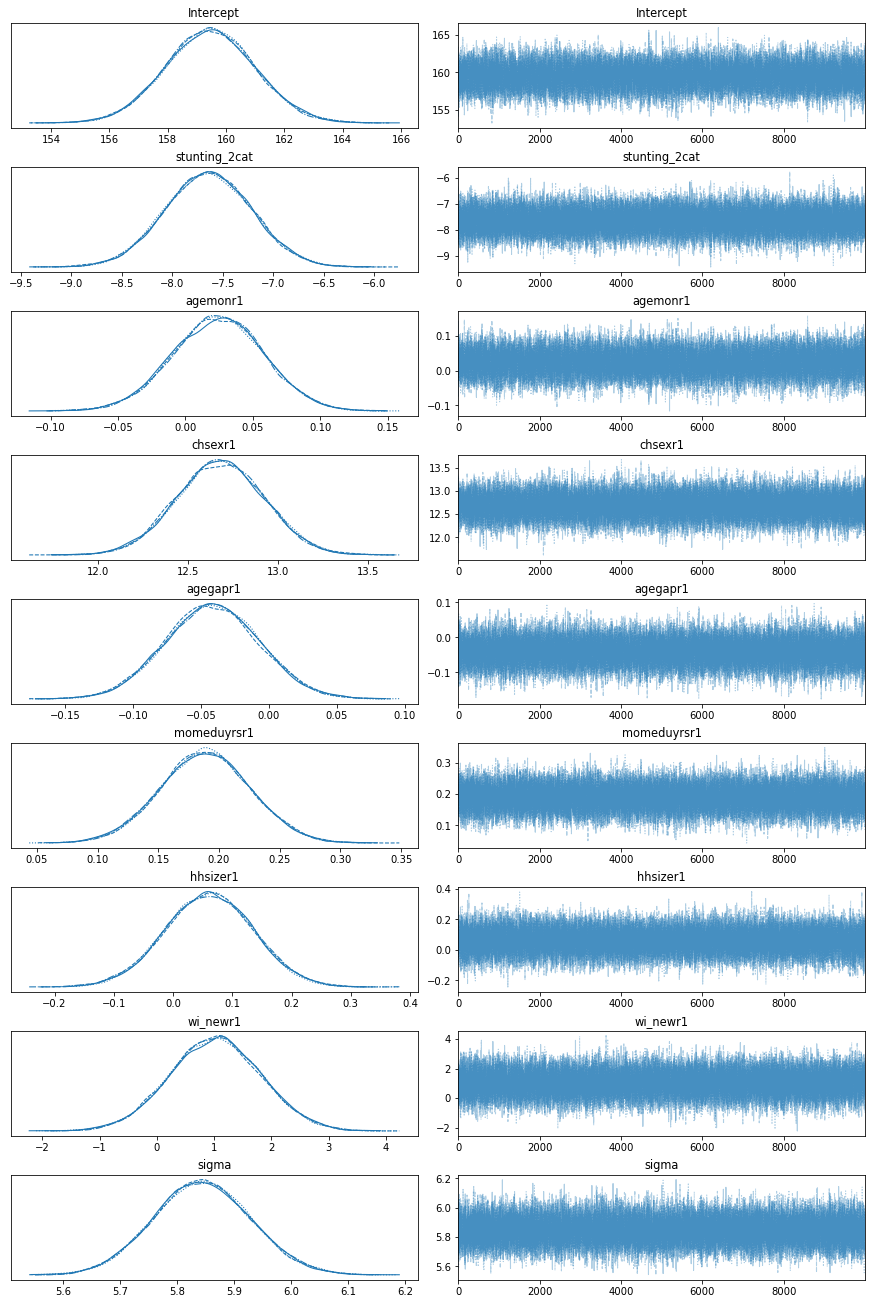

In [35]:
az.plot_trace(linear_trace)

There are a couple of things to notice here:
Our sampling chains for the individual parameters (left) seem well converged and stationary (there are no large drifts or other odd patterns).
The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

Here we can see that our model parameters are not point estimates but distributions. The mean of each distribution can be taken as the most likely estimate, but we also use the entire range of values to show we are uncertain about the true values.

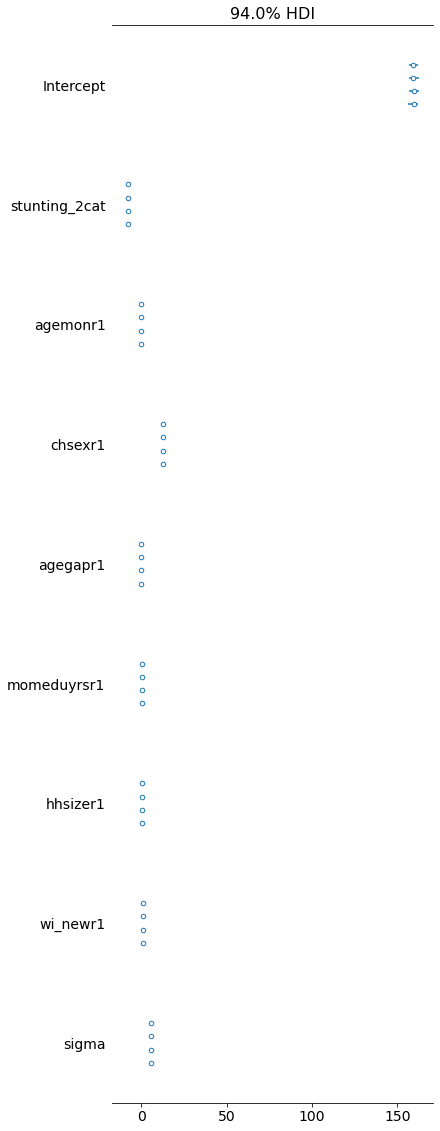

In [36]:
az.plot_forest(linear_trace);

# Trace Plot of All Samples

In [41]:
import matplotlib.pyplot as plt
import matplotlib

In [44]:
# Define a function to draw posterior plot
def posterior_plot (variable, xlabel):
    _, ax = plt.subplots(figsize = (12, 6))
    ax.hist([n.mean() for n in linear_trace[variable]], bins = 19, alpha = 0.5 , color = 'gray', edgecolor = 'black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(title = 'Posterior predictive of ' + xlabel, xlabel = xlabel, ylabel = 'Frequency')

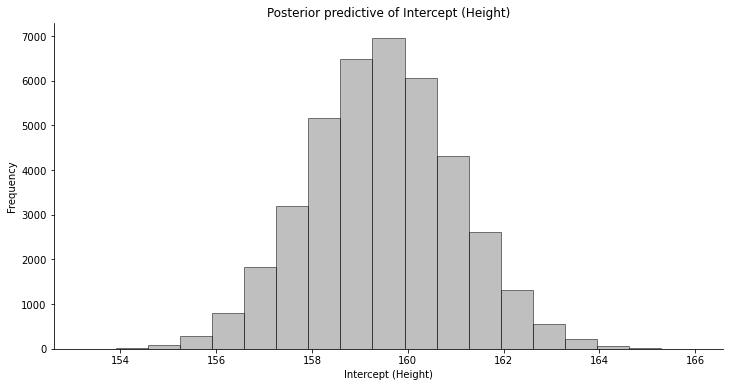

In [45]:
posterior_plot ('Intercept', 'Intercept (Height)')

In [48]:
df_brazil.columns

Index(['height', 'stunting_2cat', 'EDUYRS2', 'z_score', 'agegapr1',
       'momeduyrsr1', 'chsexr1', 'agemonr1', 'hhsizer1', 'wi_newr1', 'job_cat',
       'pvt_sector', 'earn_usd'],
      dtype='object')

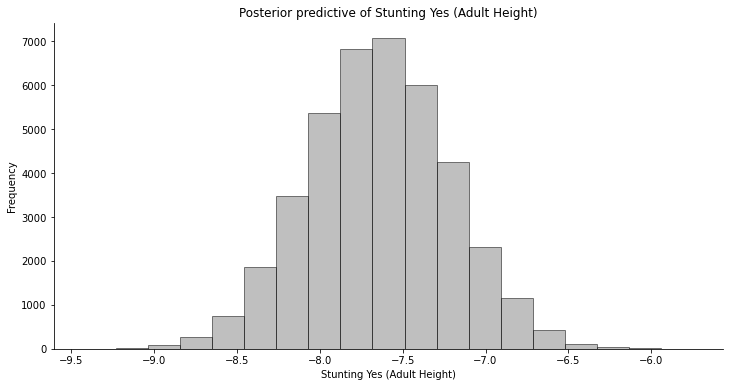

In [46]:
posterior_plot ('stunting_2cat', 'Stunting Yes (Adult Height)')

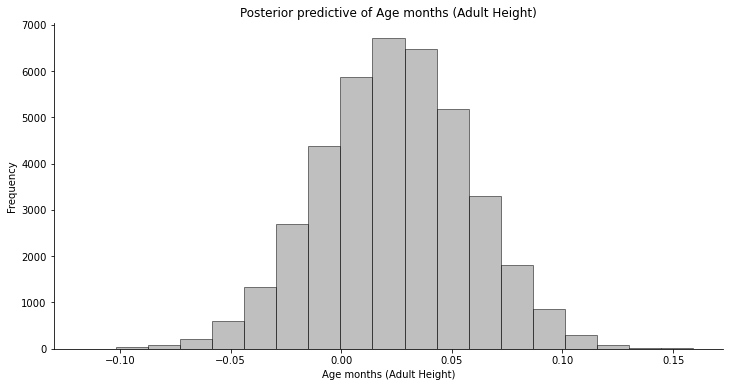

In [49]:
posterior_plot ('agemonr1', 'Age months (Adult Height)')

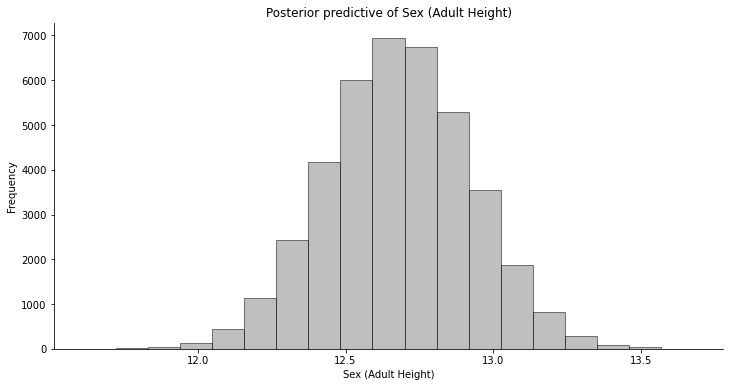

In [50]:
posterior_plot ('chsexr1', 'Sex (Adult Height)')

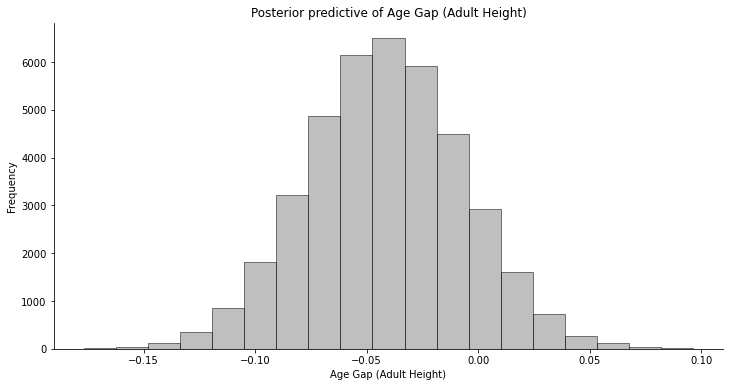

In [51]:
posterior_plot ('agegapr1', 'Age Gap (Adult Height)')

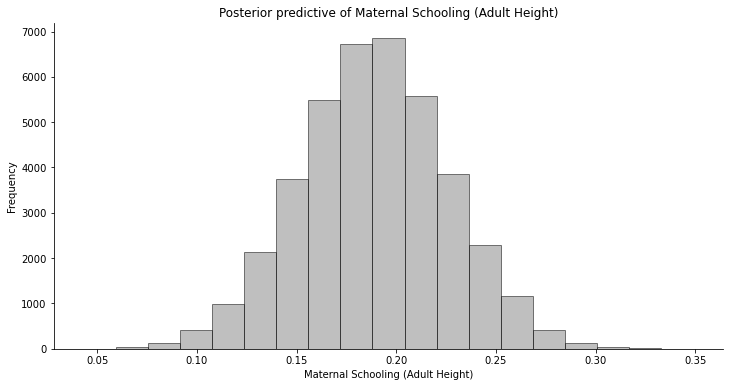

In [52]:
posterior_plot ('momeduyrsr1', 'Maternal Schooling (Adult Height)')

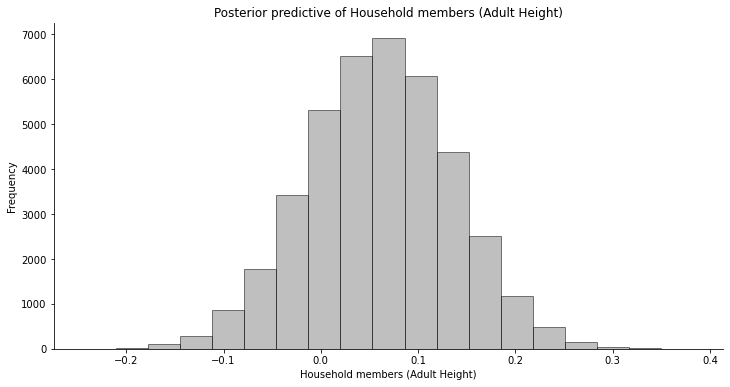

In [53]:
posterior_plot ('hhsizer1', 'Household members (Adult Height)')

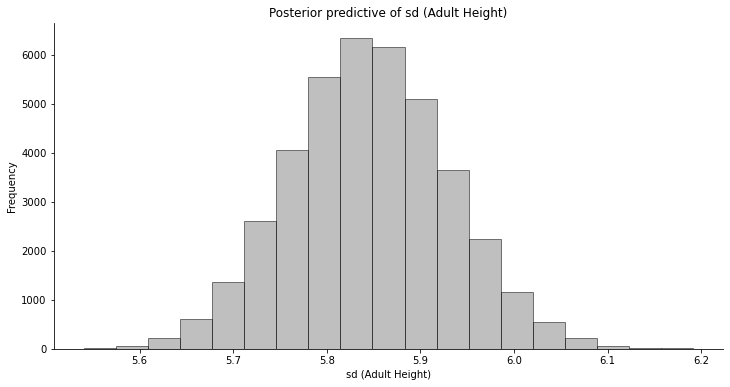

In [55]:
posterior_plot ('sigma', 'sd (Adult Height)')

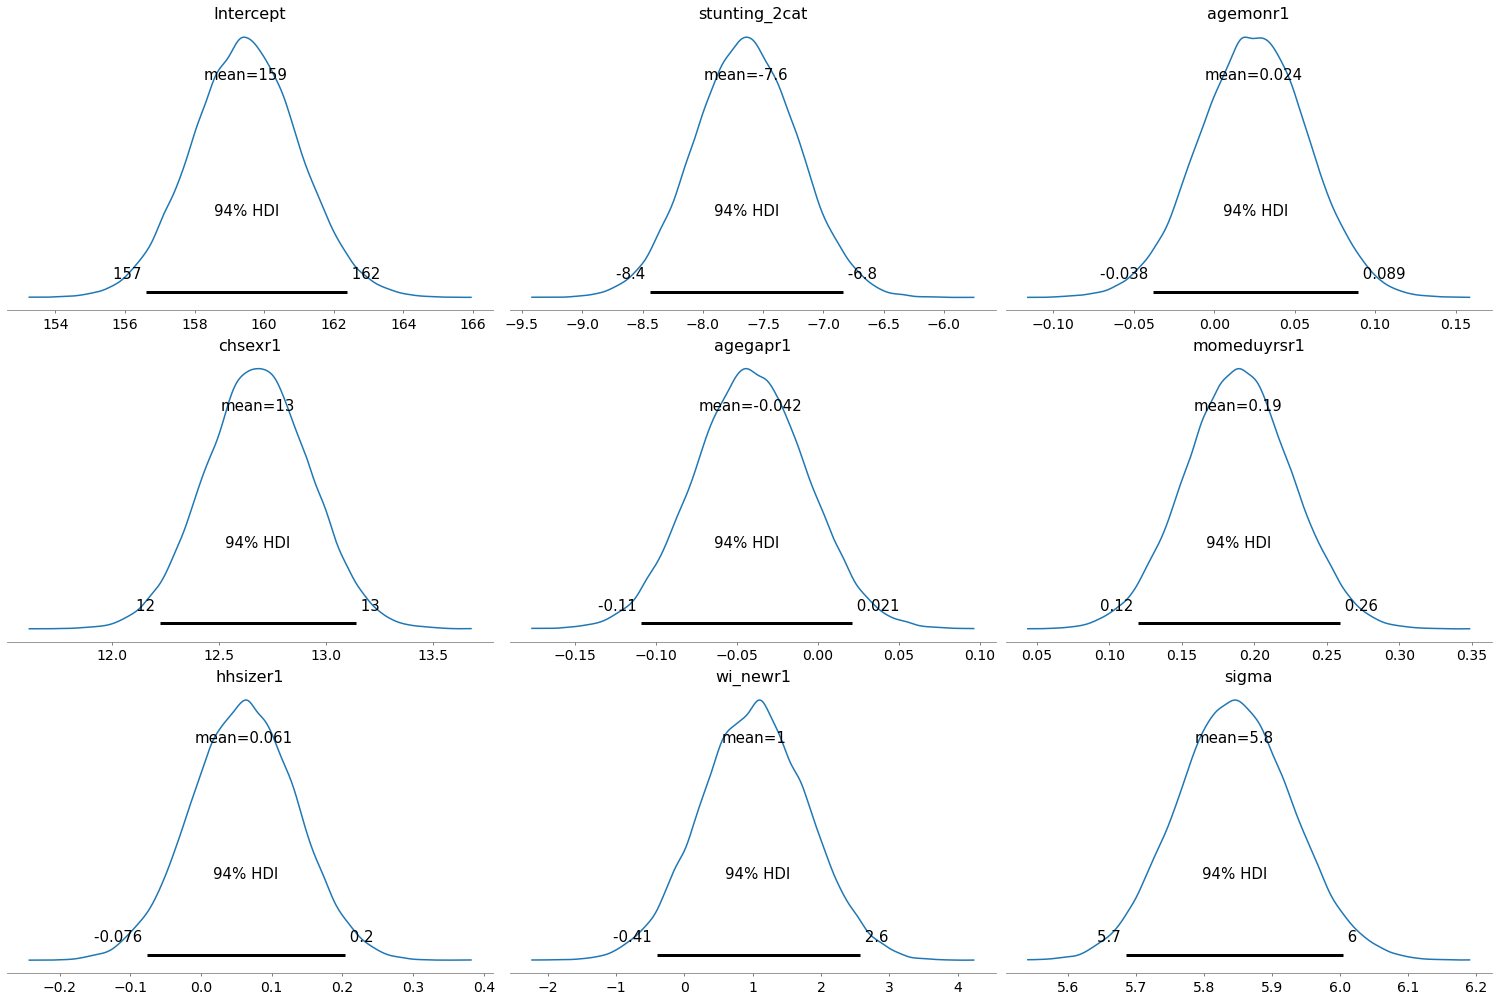

In [56]:
az.plot_posterior(linear_trace);

In [57]:
for variable in linear_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(linear_trace[variable])))

Variable: Intercept       Mean weight in model: 159.4637
Variable: stunting_2cat   Mean weight in model: -7.6451
Variable: agemonr1        Mean weight in model: 0.0242
Variable: chsexr1         Mean weight in model: 12.6800
Variable: agegapr1        Mean weight in model: -0.0416
Variable: momeduyrsr1     Mean weight in model: 0.1889
Variable: hhsizer1        Mean weight in model: 0.0607
Variable: wi_newr1        Mean weight in model: 1.0190
Variable: sigma_log__     Mean weight in model: 1.7655
Variable: sigma           Mean weight in model: 5.8451


# Examines the effect of changing a single variable


In [69]:
# Takes in the name of the variable, the trace, and the data
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('Height', size = 16)
    plt.title("Posterior of Adult Height  vs %s" % query_var, size = 18)
    plt.show()

# Model Variable Effects

If we want to see the effect of changing one variable while holding the others constant, we can use the function pm.plot_posterior_predictive_glm. This takes a range of values to use for the variable, a linear model, and a number of samples. The function evaluates the linear model across the range of values for the number of samples. Each time, it draws a different set of parameters from the trace. This gives us an indication of the effect of a single variable and also the uncertainty in the model estimates. To see the effect of a single variable, we hold the others constant at their median values.

In [70]:
import matplotlib.pyplot as plt

In [64]:
df_model=df_knn_imp.drop(['z_score', 'EDUYRS2','earn_usd','job_cat','pvt_sector'], axis='columns', inplace=True)

In [73]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

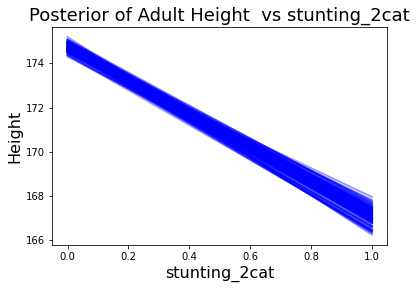

In [74]:
model_effect('stunting_2cat', linear_trace, df_knn_imp.drop(columns='height'))

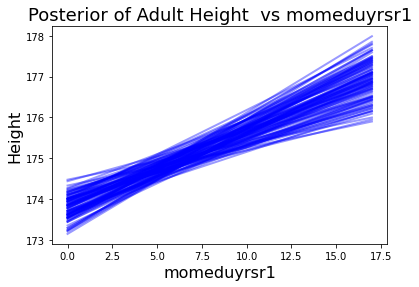

In [75]:
model_effect('momeduyrsr1', linear_trace, df_knn_imp.drop(columns='height'))

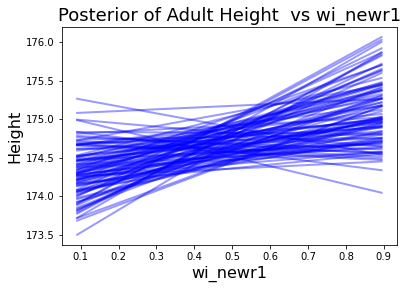

In [76]:
model_effect('wi_newr1', linear_trace, df_knn_imp.drop(columns='height'))
